In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import cv2


In [2]:
torch.cuda.device_count()

1

In [3]:
# Set parameters
IMG_HEIGHT = 181
IMG_WIDTH = 181
BATCH_SIZE = 32
NUM_CLASSES = 2  # Black and White pieces
EPOCHS = 10
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device: {DEVICE}')


Using device: cuda


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Resize images to the target size
    transforms.RandomRotation(20),  # Randomly rotate images by up to 20 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally (50% chance)
    transforms.RandomResizedCrop(IMG_HEIGHT, scale=(0.8, 1.0)),  # Randomly crop and resize the image to a given size (crop between 80% and 100% of the original image)
    transforms.ToTensor(),  # Convert image to a tensor (normalizes pixel values to [0, 1])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image using the standard ImageNet values for mean and std
])


val_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Resize images to the target size
    transforms.ToTensor(),  # Convert image to a tensor (normalizes pixel values to [0, 1])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image using the same values as for training
])



In [ ]:
train_dataset = datasets.ImageFolder('color train', transform=train_transforms)
val_dataset = datasets.ImageFolder('color valid', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Classes: {train_dataset.classes}")


Classes: ['black', 'white']


In [ ]:
# Load pretrained MobileNetV2
base_model = models.mobilenet_v2(pretrained=True)
base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, NUM_CLASSES)
base_model = base_model.to(DEVICE)

# Print model architecture
print(base_model)


c:\Users\yassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=LEARNING_RATE)


In [8]:
# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=EPOCHS):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_preds = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())

        model.eval()
        val_running_loss, val_correct_preds = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels)

        val_loss_epoch = val_running_loss / len(val_loader.dataset)
        val_acc_epoch = val_correct_preds.double() / len(val_loader.dataset)
        val_loss.append(val_loss_epoch)
        val_acc.append(val_acc_epoch.item())

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

    return train_loss, val_loss, train_acc, val_acc


In [9]:
# Train the model
train_loss, val_loss, train_acc, val_acc = train_model(base_model, criterion, optimizer, train_loader, val_loader)


Epoch 1/10, Train Loss: 0.0533, Train Acc: 0.9838, Val Loss: 0.0023, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0022, Train Acc: 1.0000, Val Loss: 0.0008, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.0002, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


In [10]:
# Save the entire model
torch.save(base_model, 'chess_color_classifier.pth')


In [11]:
# # Saving the model
# torch.save(base_model.state_dict(), 'chess_piece_classifier.pth')
# print("Model saved successfully!")


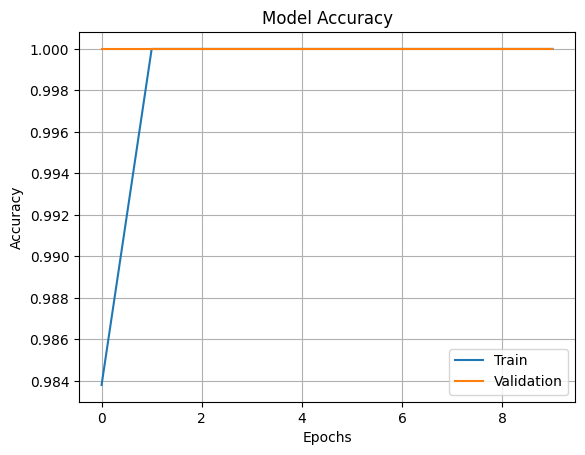

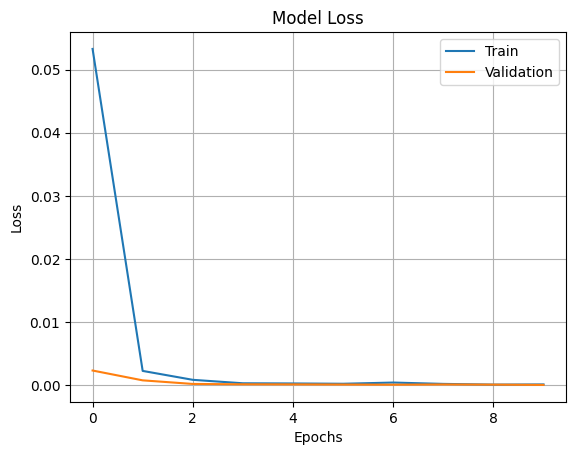

In [12]:
# Plot accuracy and loss
def plot_metrics(train_metric, val_metric, metric_name='Accuracy'):
    plt.plot(train_metric, label='Train')
    plt.plot(val_metric, label='Validation')
    plt.title(f'Model {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy and loss
plot_metrics(train_acc, val_acc, 'Accuracy')
plot_metrics(train_loss, val_loss, 'Loss')


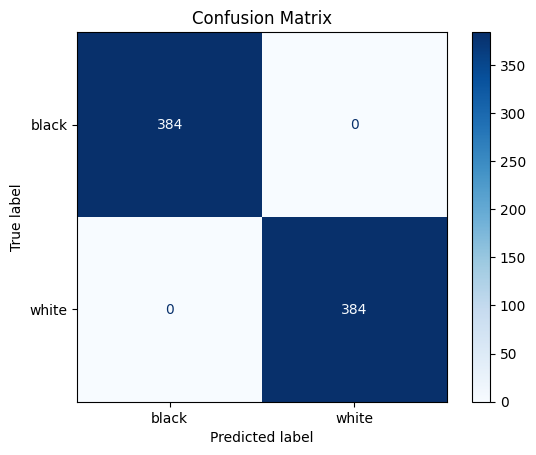

In [13]:
# Evaluate the model and show confusion matrix
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    return all_preds, all_labels

# Get predictions and labels
y_pred, y_true = evaluate_model(base_model, val_loader)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [14]:
# Make predictions on custom images
def predict_image(model, image_path, transform, class_names):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)
    
    return class_names[pred.item()]


In [15]:
# Test prediction on your images
class_names = train_dataset.classes
predictions = []

for i in range(64):
    img_path = f'actual pieces/pic{i}.png'
    predicted_class = predict_image(base_model, img_path, val_transforms, class_names)
    predictions.append(predicted_class)
    print(f"Image {i}: Predicted class = {predicted_class}")


Image 0: Predicted class = black
Image 1: Predicted class = black
Image 2: Predicted class = black
Image 3: Predicted class = white
Image 4: Predicted class = black
Image 5: Predicted class = black
Image 6: Predicted class = white
Image 7: Predicted class = black
Image 8: Predicted class = black
Image 9: Predicted class = black
Image 10: Predicted class = white
Image 11: Predicted class = black
Image 12: Predicted class = white
Image 13: Predicted class = black
Image 14: Predicted class = black
Image 15: Predicted class = black
Image 16: Predicted class = white
Image 17: Predicted class = white
Image 18: Predicted class = black
Image 19: Predicted class = white
Image 20: Predicted class = black
Image 21: Predicted class = black
Image 22: Predicted class = white
Image 23: Predicted class = white
Image 24: Predicted class = white
Image 25: Predicted class = white
Image 26: Predicted class = white
Image 27: Predicted class = white
Image 28: Predicted class = white
Image 29: Predicted clas

In [16]:
def display_images_with_predictions(images, predictions):
    # Create a figure to plot the images
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))  # Create an 8x8 grid

    # Loop through images and predictions
    for i in range(len(images)):
        # Load each image
        img = cv2.imread(images[i])  # Read the image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display

        # Get the current axis in the grid
        ax = axes[i // 8, i % 8]

        # Display the image
        ax.imshow(img)
        ax.set_title(predictions[i])  # Set prediction as title

        # Turn off the axis
        ax.axis('off')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


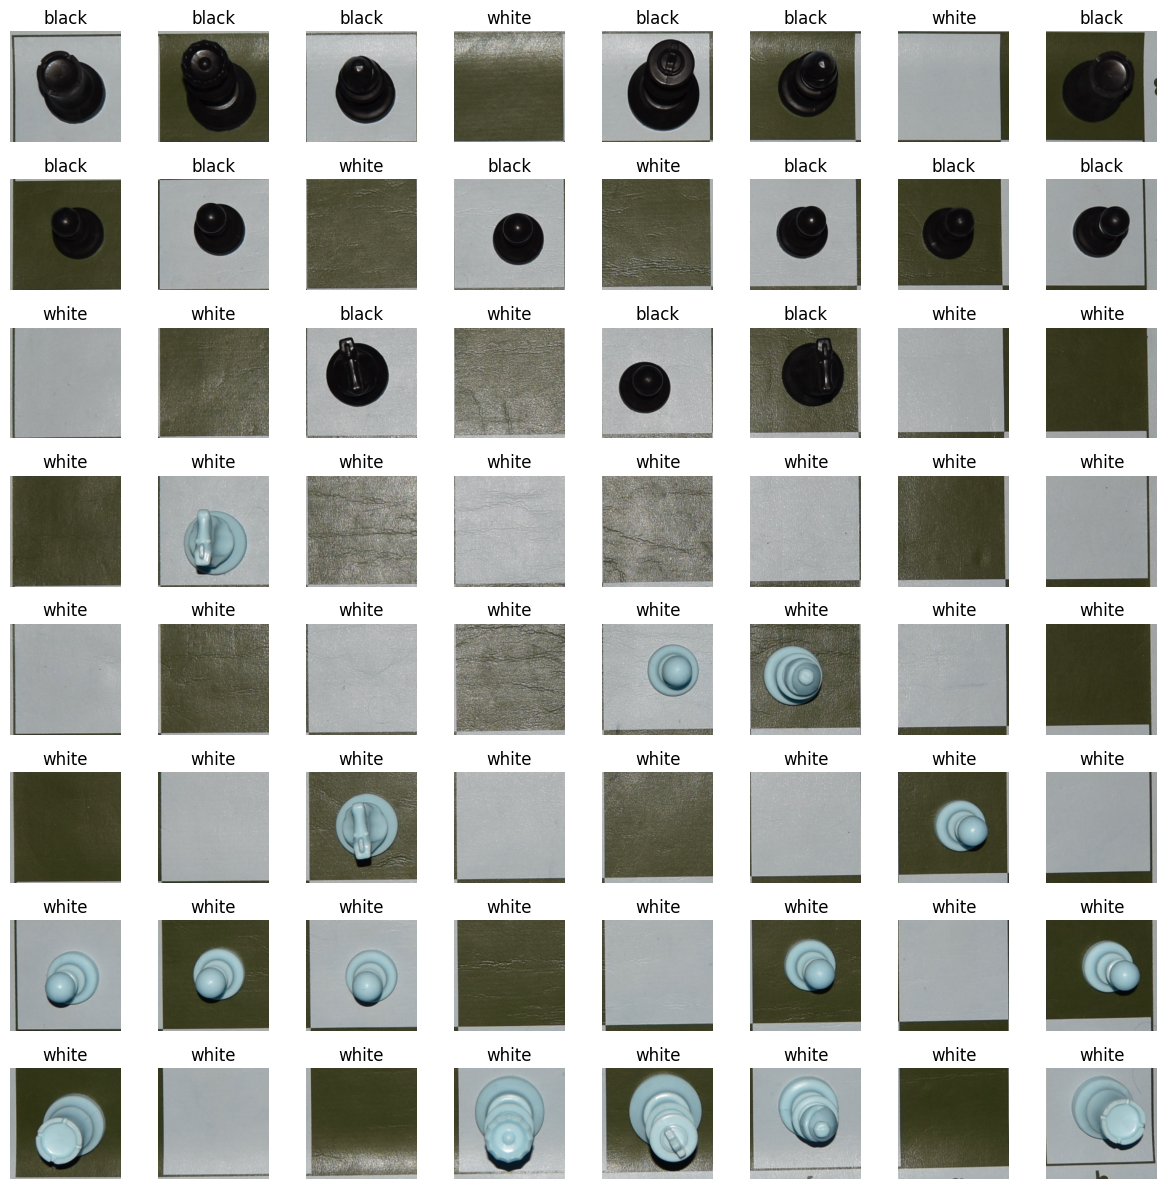

In [17]:
# Prepare the image paths
images_array = [f'actual pieces/pic{i}.png' for i in range(64)]

# Call the function to display images and predictions
display_images_with_predictions(images_array, predictions)
